In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
data_dir = "/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km"
kw = {"decode_timedelta": True}

In [4]:
nice_names = {
    "sp": "Surface Pressure",
    "u10": "10m Zonal Wind",
    "v10": "10m Meridional Wind",
    "t2m": "2m Temperature",
    "sh2": "2m Specific Humidity",
    "gh": "Geopotential Height",
    "u": "Zonal Wind",
    "v": "Meridional Wind",
    "w": "Vertical Velocity",
    "t": "Temperature",
    "q": "Specific Humidity",
}

In [5]:
def plot_spectra(fhr, dsdict):

    
    try:
        outer = list(dsdict.values())[0]
        xds = list(outer.values())[0]
        ncols = len(xds.data_vars)
    except:
        xds = list(dsdict.values())[0]
        ncols = len(xds.data_vars)
        
    fig, axs = plt.subplots(1, ncols, figsize=(5*ncols, 4.5), constrained_layout=True, sharey=True)

    for label, xds in dsdict.items():
        for varname, ax in zip(xds.data_vars, axs):
            xds[varname].sel(fhr=fhr).plot(ax=ax, label=label)

    # Now use the last dataset to get fhr0 as a "truth" comparison
    for varname, ax in zip(xds.data_vars, axs):
        xds[varname].sel(fhr=0).plot(ax=ax, label="Analysis", color="gray")

        ax.set(
            yscale="log",
            xscale="log",
            title=f"{nice_names[varname]}\nLead Time = {fhr}h",
            xlabel="$k$",
            ylabel="$P(k)$" if ax.get_subplotspec().is_first_col() else "",
        )
        ax.legend(loc="lower left")
    return fig, axs
    #fig.savefig(f"figures/channels_spectra_{fhr:03d}h.jpeg", bbox_inches="tight", dpi=300)

## CRPS

In [6]:
loss = {
    domain: {
        "mse06h": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/inference-validation/spectra.nested-{domain}.nc", **kw),
        "crps06h - gridx4": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/no-truncation/inference-validation/spectra.nested-{domain}.nc", **kw),
        "crps06h - 32": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/noise32/inference-validation/spectra.nested-{domain}.nc", **kw),
        "crps06h - 128": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/noise128/inference-validation/spectra.nested-{domain}.nc", **kw),
    }
    for domain in ["lam", "global"]
}

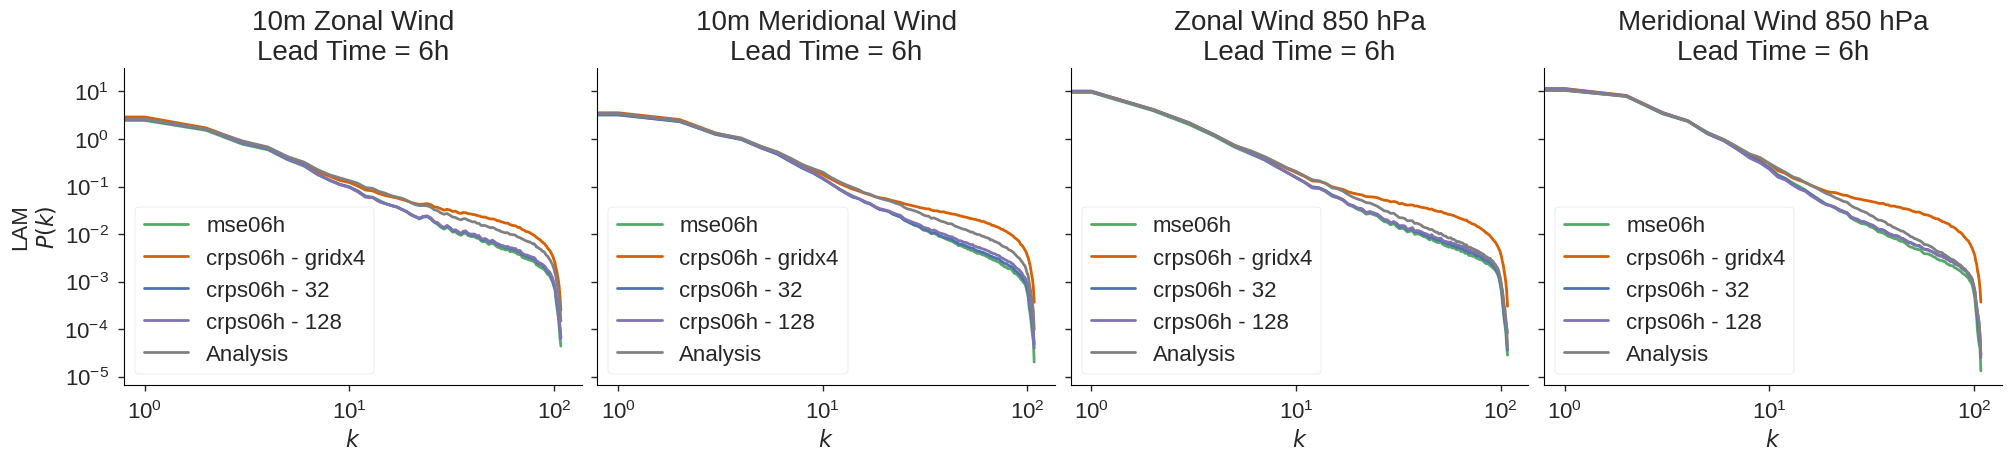

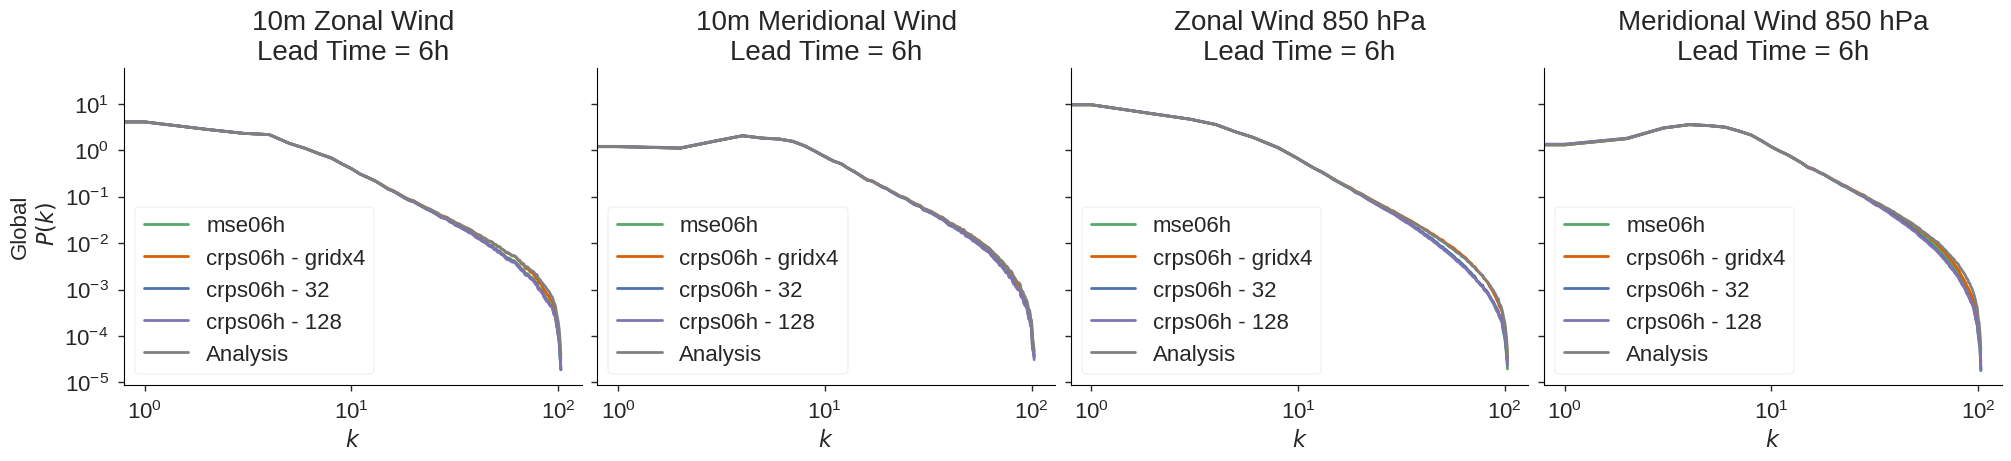

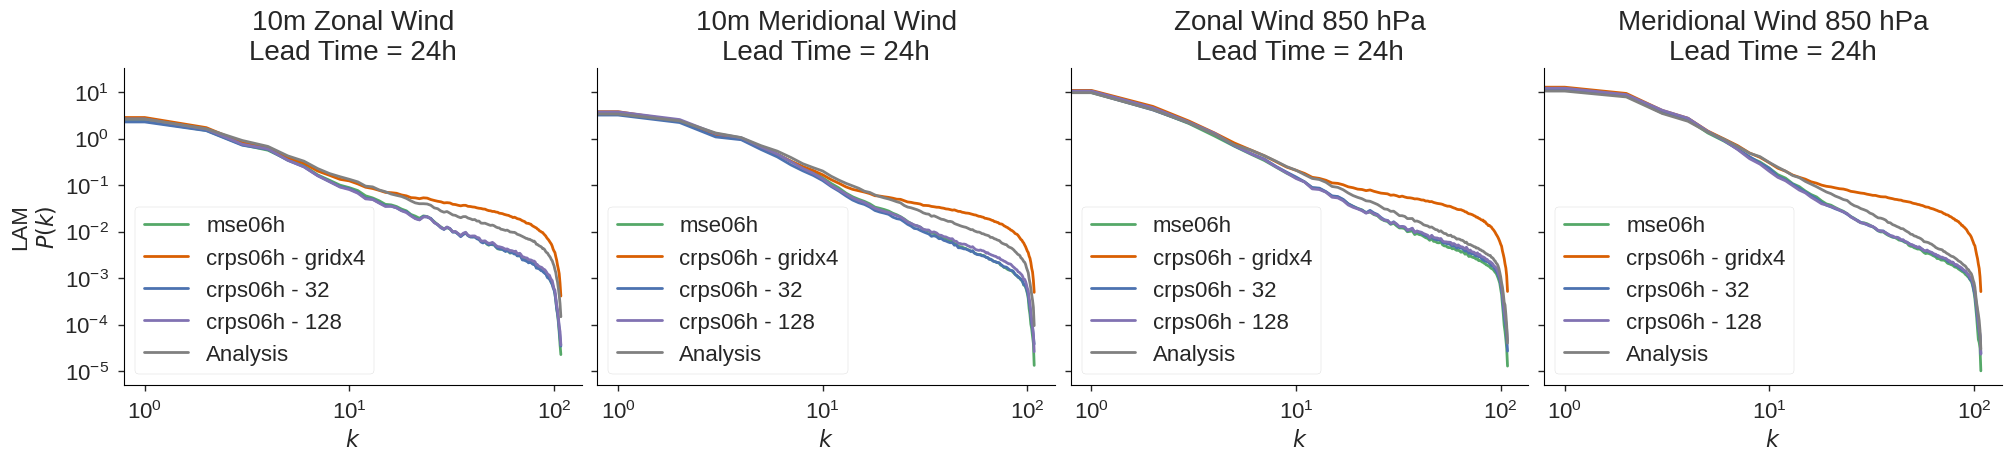

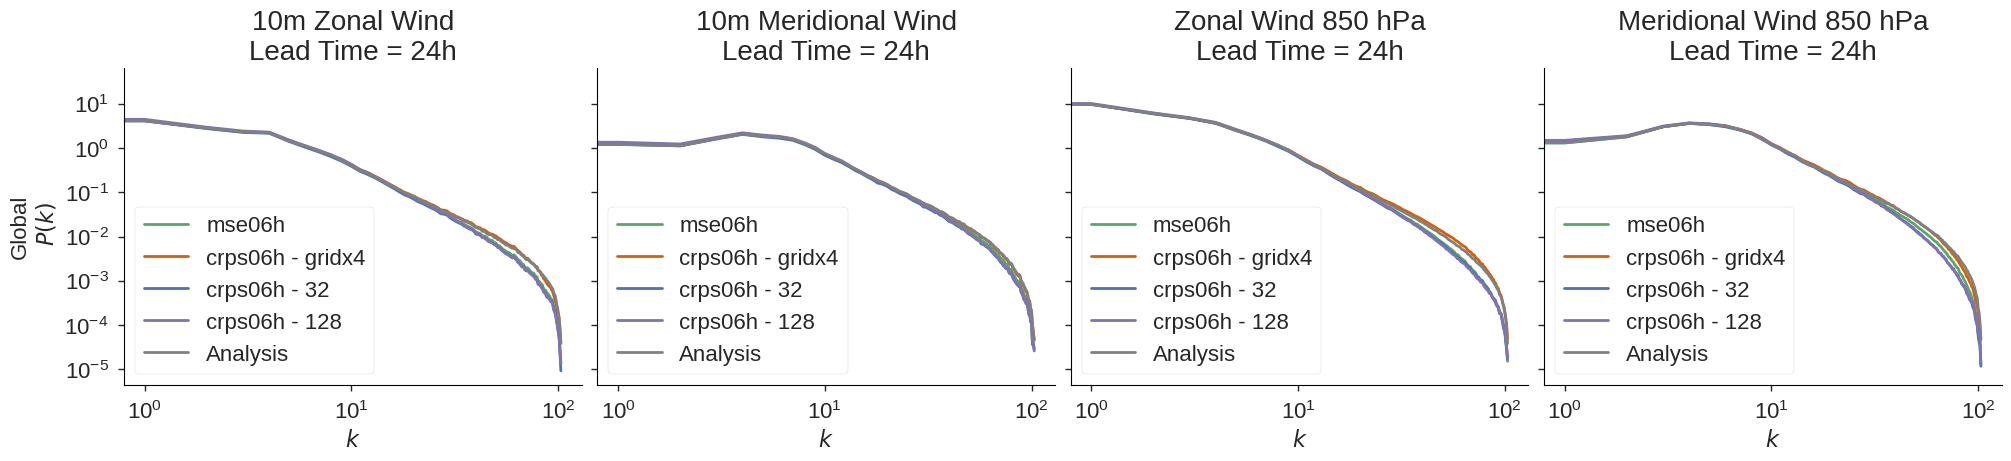

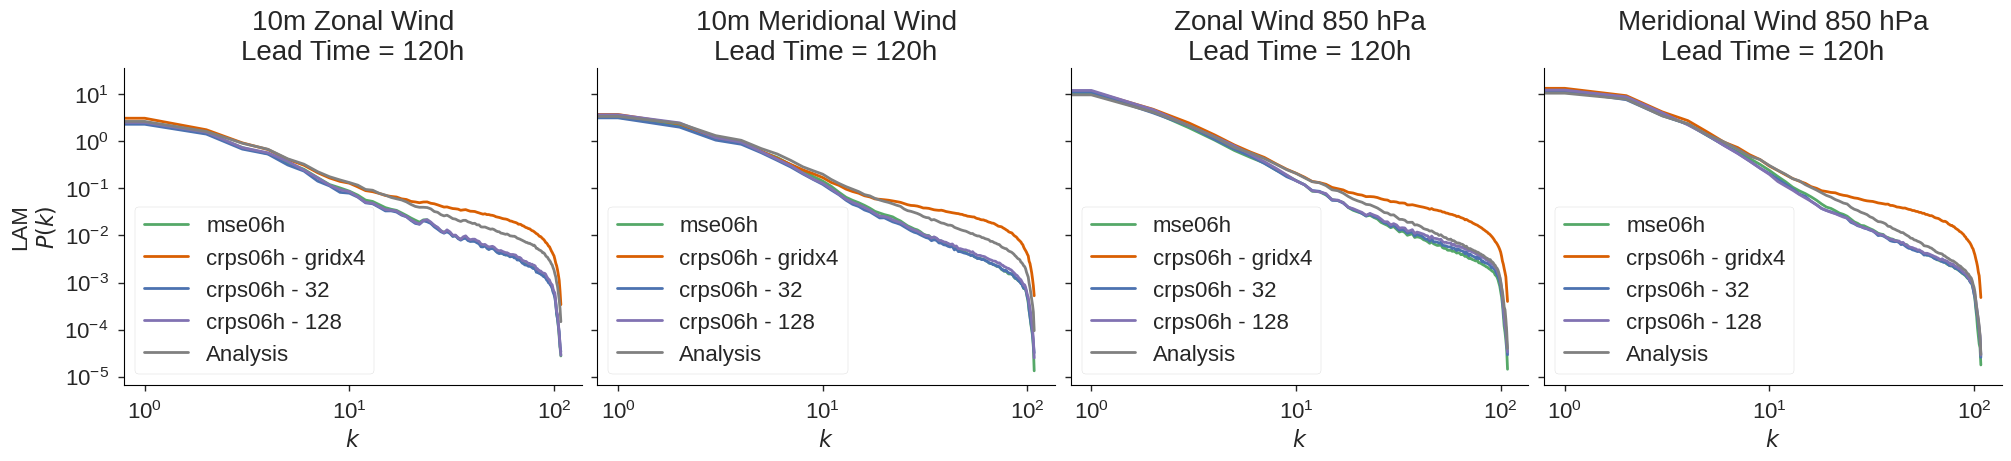

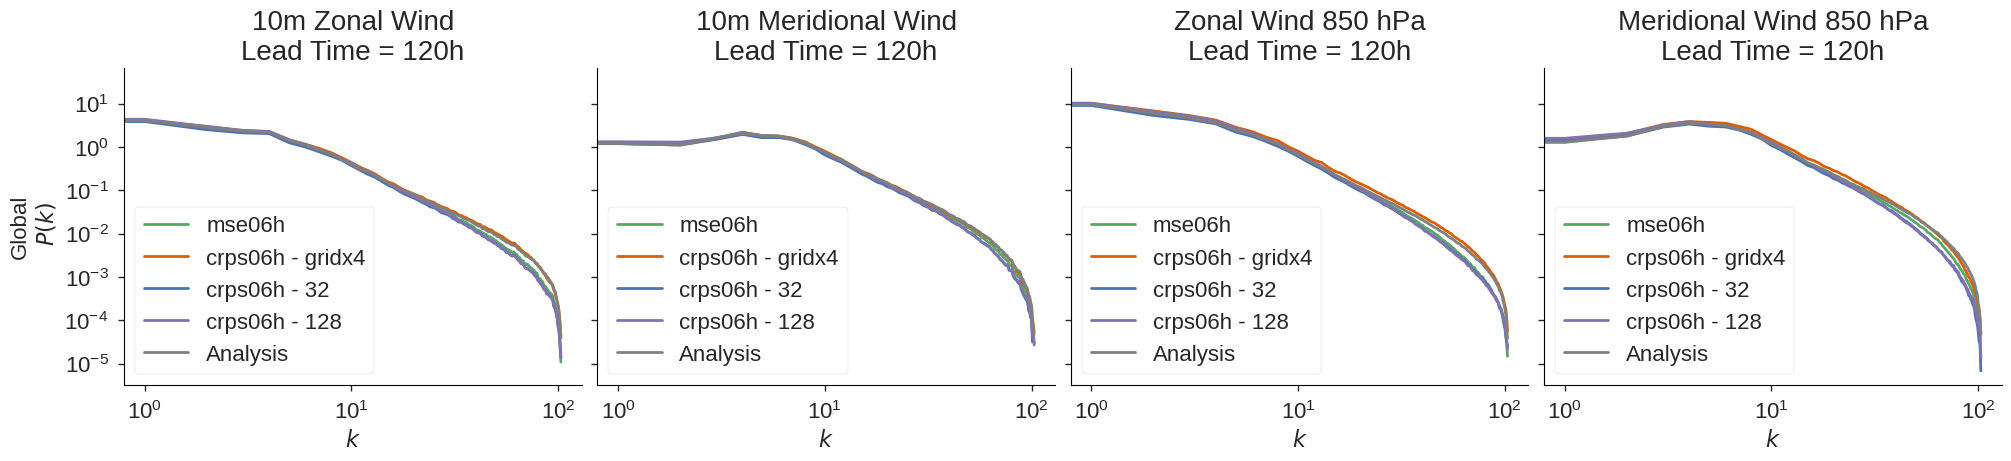

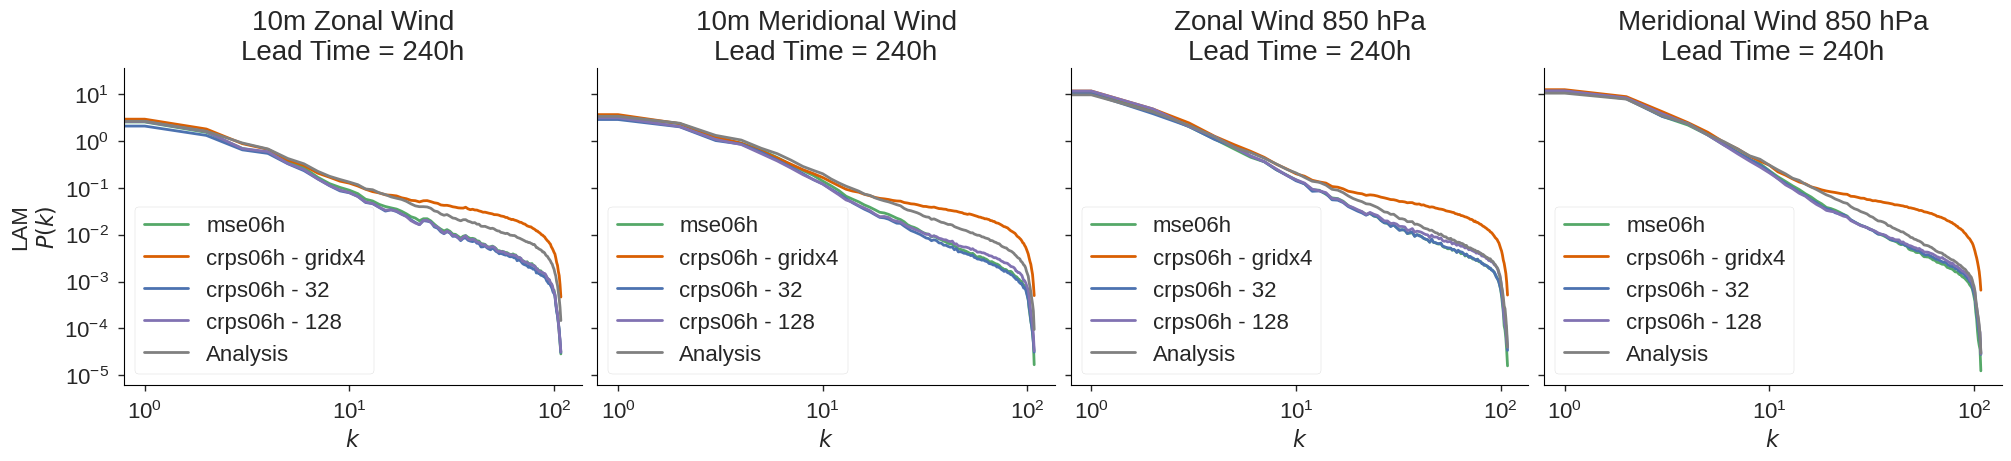

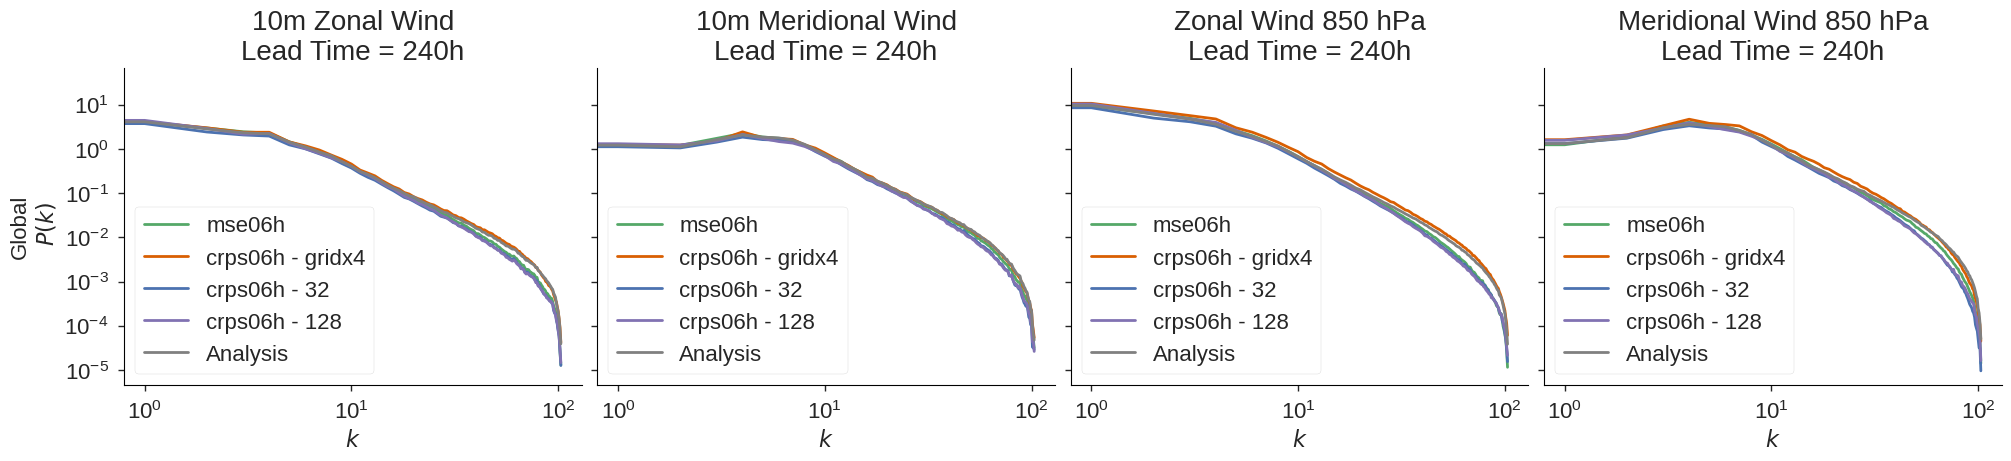

In [7]:
for fhr in [6, 24, 120, 240]:
    fig, axs = plot_spectra(fhr=fhr, dsdict=loss["lam"])
    for idx in [2, 3]:
        axs[idx].set_title(axs[idx].get_title().replace("Wind", "Wind 850 hPa"))
    axs[0].set_ylabel("LAM\n" + axs[0].get_ylabel())
    fig, axs = plot_spectra(fhr=fhr, dsdict=loss["global"])
    for idx in [2, 3]:
        axs[idx].set_title(axs[idx].get_title().replace("Wind", "Wind 850 hPa"))
    axs[0].set_ylabel("Global\n " + axs[0].get_ylabel())